Model creation and evaluation

--Module and data imports

In [1]:
from download import import_data_module
from data_preprocess import data_cleaner_module
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import randint, uniform
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

data = import_data_module.import_dataframe_from_csv("../model_data/CrabAgePrediction.csv")
data_cleaned = data_cleaner_module.clean_Data(data)

data_cleaned.reset_index(drop=True, inplace=True)

Linear Regression Ridge

-- Enrichment

In [2]:
print(data_cleaned.columns)

Index(['Sex', 'Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight', 'Age'],
      dtype='object')


In [3]:
feature = data_cleaned.drop(columns=['Age'])
target = data_cleaned["Age"]

feature["Volume"] = feature["Length"] * feature["Height"] * feature["Diameter"]
feature["Weight proportion"] = (feature["Shucked Weight"] + feature["Viscera Weight"] + feature["Shell Weight"]) / feature["Weight"]
feature["Shucked proportion"] = feature["Shucked Weight"] / feature["Weight"]
feature["Viscera proportion"] = feature["Viscera Weight"] / feature["Weight"]
feature["Shell proportion"] = feature["Shell Weight"] / feature["Weight"]

-- Encoding and standarization

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

cols_to_scale = feature.select_dtypes(include=['float', 'int']).columns

scaled_data = scaler.fit_transform(feature[cols_to_scale])

scaled_feature = pd.DataFrame(scaled_data, columns=cols_to_scale)

scaled_feature = pd.concat([scaled_feature, feature.drop(columns=cols_to_scale)], axis=1)


In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

cols_to_encode = feature.select_dtypes(include=['object']).columns

encoded_data = label_encoder.fit_transform(feature[cols_to_encode[0]].values)

encoded_feature = pd.DataFrame(encoded_data, columns=cols_to_encode)

prepared_feature = pd.concat([encoded_feature, scaled_feature.drop(columns=cols_to_encode)], axis=1)

-- Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(prepared_feature, target, test_size=0.35, random_state=0)

--model

In [8]:
from sklearn.linear_model import Ridge

linear_model = Ridge(alpha=3.0753460654447227)

linear_model.fit(X_train, y_train)

print("Intercept: ", linear_model.intercept_)
print("Coefficients: ", linear_model.coef_)

linear_predictions = linear_model.predict(X_test)

Intercept:  9.853155524267377
Coefficients:  [ 0.03870418 -0.2234252   1.26227036  1.40953401  4.85972565 -3.79706643
 -0.57948278  0.74997878 -1.82367412  0.10136833 -0.03452746 -0.10893238
  0.32622016]


Linear Evaluation

Mae: 1.508708313703417
 Mse: 4.562335974246049 
 RMSE: 2.1359625404594644 
 R2: 0.5550630054992993


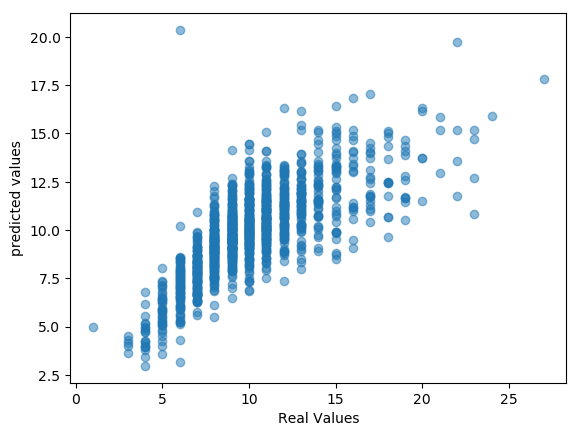

In [9]:
ridge_mae = mean_absolute_error(y_test, linear_predictions)
ridge_mse = mean_squared_error(y_test, linear_predictions)
ridge_r2 = r2_score(y_test, linear_predictions)

print(f"Mae: {ridge_mae}\n Mse: {ridge_mse} \n RMSE: {math.sqrt(ridge_mse)} \n R2: {ridge_r2}")

plt.scatter(y_test, linear_predictions, alpha=0.5)
plt.xlabel("Real Values")
plt.ylabel("predicted values")
plt.show()

Linear cv

In [10]:
linear_cv = cross_val_score(linear_model, prepared_feature, target, cv=5)

print(f"Scores: {linear_cv}\n Mean: {linear_cv.mean()}\n Devation: {linear_cv.std()}")

Scores: [0.49167462 0.55766928 0.52261613 0.28604136 0.60049861]
 Mean: 0.4916999977232669
 Devation: 0.10903244028147387


Linear random search for hyperparams

In [11]:
params = {
    'alpha': uniform(0.1, 10), 
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

linear_search = RandomizedSearchCV(linear_model, param_distributions=params, n_iter=4, cv=5, random_state=0, error_score='raise')

linear_search.fit(X_train, y_train)

print(f"Best params: {linear_search.best_estimator_}")

Best params: Ridge(alpha=3.0753460654447227)


-----------------------------------------------------------------------------------------------------------------------------------------------------

Random forest

-- enrichment

In [12]:
print(data_cleaned.columns)

Index(['Sex', 'Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight',
       'Viscera Weight', 'Shell Weight', 'Age'],
      dtype='object')


In [13]:
feature = data_cleaned.drop(columns=['Age'])
target = data_cleaned["Age"]

feature["Volume"] = feature["Length"] * feature["Height"] * feature["Diameter"]
feature["Weight proportion"] = (feature["Shucked Weight"] + feature["Viscera Weight"] + feature["Shell Weight"]) / feature["Weight"]
feature["Shucked proportion"] = feature["Shucked Weight"] / feature["Weight"]
feature["Viscera proportion"] = feature["Viscera Weight"] / feature["Weight"]
feature["Shell proportion"] = feature["Shell Weight"] / feature["Weight"]
feature["Shell area"] = (feature["Diameter"] / 2)**2 * math.pi

-- Encoding and standarization

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

cols_to_scale = feature.select_dtypes(include=['float', 'int']).columns

scaled_data = scaler.fit_transform(feature[cols_to_scale])

scaled_feature = pd.DataFrame(scaled_data, columns=cols_to_scale)

scaled_feature = pd.concat([scaled_feature, feature.drop(columns=cols_to_scale)], axis=1)


In [15]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

cols_to_encode = feature.select_dtypes(include=['object']).columns

encoded_data = label_encoder.fit_transform(feature[cols_to_encode[0]].values)

encoded_feature = pd.DataFrame(encoded_data, columns=cols_to_encode)

prepared_feature = pd.concat([encoded_feature, scaled_feature.drop(columns=cols_to_encode)], axis=1)

-- Split

In [16]:
X_train, X_test, y_train, y_test =  train_test_split(prepared_feature, target, test_size=0.35, random_state=42)

--model

In [17]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(max_depth=7, max_features='sqrt', min_samples_leaf=2, min_samples_split=6, n_estimators=215)

rf_model.fit(X_train, y_train)

rf_predict = rf_model.predict(X_test)

Random forest evaluation

Mae: 1.5097654130765998
 Mse: 4.4547172638667885 
 RMSE: 2.1106201135843436 
 R2: 0.5684519511555262


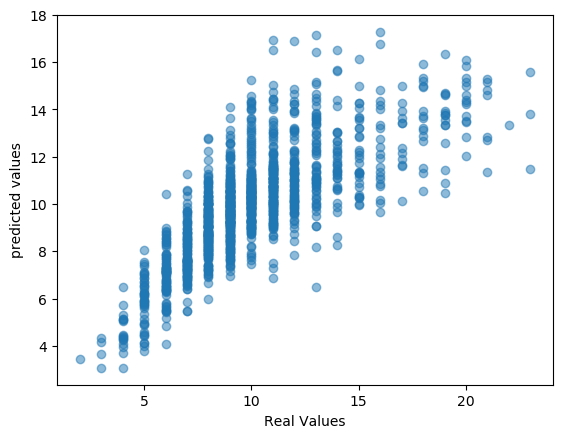

In [18]:
rf_mae = mean_absolute_error(y_test, rf_predict)
rf_mse = mean_squared_error(y_test, rf_predict)
rf_r2 = r2_score(y_test, rf_predict)

print(f"Mae: {rf_mae}\n Mse: {rf_mse} \n RMSE: {math.sqrt(rf_mse)} \n R2: {rf_r2}")

plt.scatter(y_test, rf_predict, alpha=0.5)
plt.xlabel("Real Values")
plt.ylabel("predicted values")
plt.show()

Random forest cross validation

In [19]:
rf_scores = cross_val_score(rf_model, prepared_feature, target, cv=5)

print(f"Scores: {rf_scores}\n Mean: {rf_scores.mean()}\n Devation: {rf_scores.std()}")

Scores: [0.56825538 0.58984601 0.53610855 0.56196379 0.61840952]
 Mean: 0.5749166489431813
 Devation: 0.027686580458046183


Random forest hyperparameters random search

In [20]:
params = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(2, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', None]
}

rf_search = RandomizedSearchCV(rf_model, param_distributions=params, n_iter=8, cv=6, random_state=0, error_score='raise')

rf_search.fit(X_train, y_train)

print(f"Best params: {rf_search.best_estimator_}")

Best params: RandomForestRegressor(max_depth=8, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=7, n_estimators=125)


------------------------

Model comparison

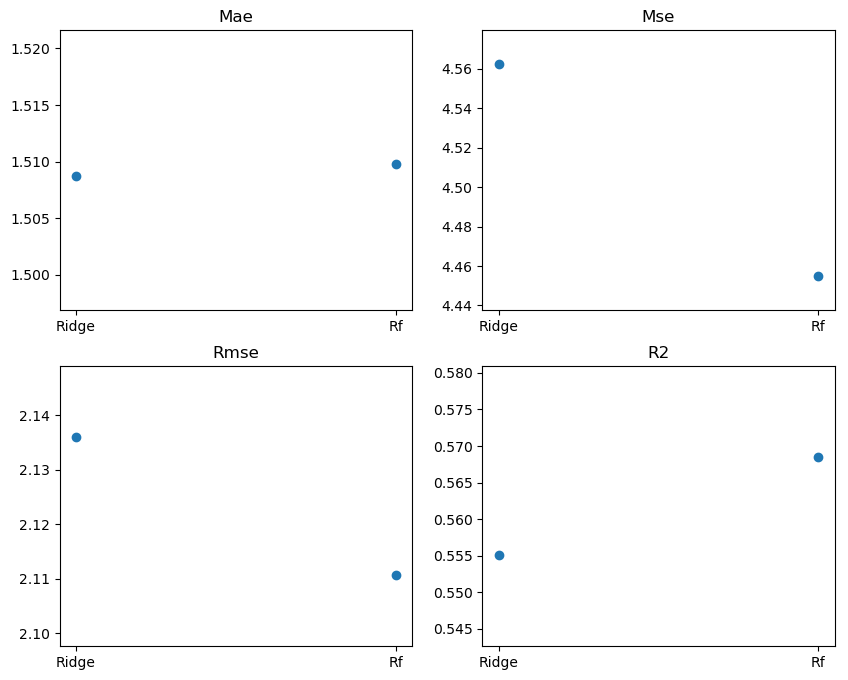

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0, 0].scatter(['Ridge', 'Rf'], [ridge_mae, rf_mae])
axs[0, 0].set_title('Mae')

axs[0, 1].scatter(['Ridge', 'Rf'], [ridge_mse, rf_mse])
axs[0, 1].set_title('Mse')

axs[1, 0].scatter(['Ridge', 'Rf'], [math.sqrt(ridge_mse), math.sqrt(rf_mse)])
axs[1, 0].set_title('Rmse')

axs[1, 1].scatter(['Ridge', 'Rf'], [ridge_r2, rf_r2])
axs[1, 1].set_title('R2')

plt.show()
